In [1]:
import sys
import os
import json
import secrets
import numpy as np

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
src_dir = os.path.join(project_dir, 'src')
data_dir = os.path.join(project_dir, 'data')
fig_dir = os.path.join(project_dir, 'fig')
logs_dir = os.path.join(project_dir, 'logs')
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

# Add the src directory to sys.path
sys.path.append(src_dir)

import torch
from opacus import PrivacyEngine
import torch.optim as optim

from dataset import get_auditable_data_loaders, generate_poisoned_canaries_and_mask
from network_arch import WideResNet
from classifier.white_box_dp_sgd import sample_gaussian, sample_mixture, ThresholdAuditor
from classifier.white_box_dp_sgd import GaussianLLRAuditor, MixtureSequenceLLRAuditor
from utils import setup_logging
from auditing import CanaryScoreAuditor

In [ ]:
# ==========================================
# Hyperparameters (Settings from the paper "Unlocking High-Accuracy Differentially Private Image Classification through Scale")
# ==========================================
LOGICAL_BATCH_SIZE = 4096     # Target batch size (Paper)
MAX_PHYSICAL_BATCH_SIZE = 128  # GPU limit (128 * 16 = 512 effective images)
AUG_MULTIPLICITY = 16         # K=16 augmentations
MAX_GRAD_NORM = 1.0
EPSILON = 8.0
DELTA = 1e-5
EPOCHS = 200                   # Increase to 100+ for best results
LR = 4.0                      # High LR for large batch
MOMENTUM = 0.0                # No momentum
NOISE_MULTIPLIER = 3.0        # Sigma ~ 3.0 is optimal for BS=4096
CKPT_INTERVAL = 20            # Save checkpoint every 10 epochs


# ==========================================
# Experiment Parameters
# ==========================================
CANARY_COUNT = 10000           # Number of canaries
PKEEP = 0.5                   # Probability of including each canary in the training set
DATABSEED = 90247832174188843591632169492264130834  # if seed is set to None then seed is random
     

In [3]:
logger, log_file = setup_logging(log_dir=logs_dir)
logdir_path = os.path.dirname(log_file) 

# Create experiment directory
if DATABSEED is not None:
    exp_dir = os.path.join(data_dir, f"white-box-canaries-{DATABSEED}-{CANARY_COUNT}-{PKEEP}-cifar10")
else:
    DATABSEED = secrets.randbits(128)
    logger.info(f"Generated random 128-bit seed: {DATABSEED}")
    exp_dir = os.path.join(data_dir, f"white-box-canaries-{DATABSEED}-{CANARY_COUNT}-{PKEEP}-cifar10")

os.makedirs(exp_dir, exist_ok=True)
logger.info(f"Experiment directory: {exp_dir}")

# Create checkpoint directory under experiment directory
ckpt_dir = os.path.join(exp_dir, "ckpt")
os.makedirs(ckpt_dir, exist_ok=True)
logger.info(f"Checkpoint directory: {ckpt_dir}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Run experiment on device: {device}")

# Set random seeds for reproducibility
# Cast 128-bit seed to 64-bit for PyTorch compatibility
torch_seed = int(DATABSEED % (2**32 - 1))
np_seed = int(DATABSEED % (2**32 - 1))
torch.manual_seed(torch_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(torch_seed)
    torch.cuda.manual_seed_all(torch_seed)
np.random.seed(np_seed)
logger.info(f"Set random seeds (torch, numpy) to: {torch_seed} (from DATABSEED: {DATABSEED})")

# Store hyperparameters in a dictionary
params = {
    'logical_batch_size': LOGICAL_BATCH_SIZE,
    'max_physical_batch_size': MAX_PHYSICAL_BATCH_SIZE,
    'aug_multiplicity': AUG_MULTIPLICITY,
    'max_grad_norm': MAX_GRAD_NORM,
    'epsilon': EPSILON,
    'delta': DELTA,
    'epochs': EPOCHS,
    'lr': LR,
    'momentum': MOMENTUM,
    'noise_multiplier': NOISE_MULTIPLIER,
    'ckpt_interval': CKPT_INTERVAL,
    'canary_count': CANARY_COUNT,
    'pkeep': PKEEP,
    'database_seed': DATABSEED
}

# Save hyperparameters to experiment directory
hparams_path = os.path.join(exp_dir, 'hparams.json')
with open(hparams_path, 'w') as f:
    json.dump(params, f, indent=2)
logger.info(f"Hyperparameters saved to: {hparams_path}")


2026-02-03 08:58:29 - INFO - Logging initialized. Log file: /storage/coda1/p-vzikas3/0/ywei368/Yu-Project/Auditing/dpsgd-auditbench/logs/train_20260203_085829.log
2026-02-03 08:58:29 - INFO - Experiment directory: /storage/coda1/p-vzikas3/0/ywei368/Yu-Project/Auditing/dpsgd-auditbench/data/white-box-canaries-27198899012190525004019618245709479116-5000-0.5-cifar10
2026-02-03 08:58:29 - INFO - Checkpoint directory: /storage/coda1/p-vzikas3/0/ywei368/Yu-Project/Auditing/dpsgd-auditbench/data/white-box-canaries-27198899012190525004019618245709479116-5000-0.5-cifar10/ckpt
2026-02-03 08:58:29 - INFO - Run experiment on device: cuda
2026-02-03 08:58:29 - INFO - Set random seeds (torch, numpy) to: 2413360701 (from DATABSEED: 27198899012190525004019618245709479116)
2026-02-03 08:58:29 - INFO - Hyperparameters saved to: /storage/coda1/p-vzikas3/0/ywei368/Yu-Project/Auditing/dpsgd-auditbench/data/white-box-canaries-27198899012190525004019618245709479116-5000-0.5-cifar10/hparams.json


In [4]:
# Load canary database and mask
print("Loading canary database and mask...")
poisoned_canaries, inclusion_mask = generate_poisoned_canaries_and_mask(
    data_dir=data_dir,
    canary_count=CANARY_COUNT,
    seed=DATABSEED,
    pkeep=PKEEP
)

print(f"Loaded {len(poisoned_canaries)} total canaries")
out_canary_count = np.sum(~inclusion_mask)
in_canary_count = np.sum(inclusion_mask)
print(f"  - In-canaries (included in training): {out_canary_count}")
print(f"  - Out-canaries (excluded from training): {in_canary_count}")

print("Loading data...")
train_dataset, test_dataset = get_auditable_data_loaders(
    data_dir=data_dir,
    canary_count=CANARY_COUNT,
    seed=DATABSEED,
    pkeep=PKEEP
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=LOGICAL_BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True
)

Loading canary database and mask...


/tmp/python-venv/dpsgd-auditbench_venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Loaded 5000 total canaries
  - In-canaries (included in training): 2540
  - Out-canaries (excluded from training): 2460
Loading data...


In [5]:
# Create initial model for score computation (only once)
torch_seed = int(DATABSEED % (2**32 - 1))
np_seed = int(DATABSEED % (2**32 - 1))
torch.manual_seed(torch_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(torch_seed)
    torch.cuda.manual_seed_all(torch_seed)
np.random.seed(np_seed)
initial_model = WideResNet(depth=16, widen_factor=4).to(device)

In [6]:
optimizer = optim.SGD(initial_model.parameters(), lr=LR, momentum=MOMENTUM)

# Setup privacy engine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=initial_model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
)

steps_per_epoch = len(train_loader) 
sample_rate = 1 / len(train_loader)
sigma = NOISE_MULTIPLIER*MAX_GRAD_NORM

print(f"Sampling rate sample_rate = {sample_rate:.6f}")
print(f"Steps/epoch (drop_last) = {steps_per_epoch}")
print(f"Score noise sigma = noise_multiplier * max_grad_norm = {sigma:.6f}")



2026-02-03 08:58:34 - WARNING - Ignoring drop_last as it is not compatible with DPDataLoader.
Sampling rate sample_rate = 0.090909
Steps/epoch (drop_last) = 11
Score noise sigma = noise_multiplier * max_grad_norm = 3.000000


/tmp/python-venv/dpsgd-auditbench_venv/lib/python3.12/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 20: Upper bound = 1.91, NIPS 23 = 0.33, Threshold = 1.92, Gaussian LLR = 1.92
Epoch 40: Upper bound = 2.78, NIPS 23 = 0.55, Threshold = 3.43, Gaussian LLR = 3.43
Epoch 60: Upper bound = 3.47, NIPS 23 = 0.62, Threshold = 3.53, Gaussian LLR = 3.53
Epoch 80: Upper bound = 4.08, NIPS 23 = 0.77, Threshold = 3.66, Gaussian LLR = 3.66
Epoch 100: Upper bound = 4.63, NIPS 23 = 0.87, Threshold = 5.14, Gaussian LLR = 5.14
Epoch 120: Upper bound = 5.14, NIPS 23 = 1.06, Threshold = 4.61, Gaussian LLR = 4.61
Epoch 140: Upper bound = 5.62, NIPS 23 = 1.07, Threshold = 5.20, Gaussian LLR = 5.20
Epoch 160: Upper bound = 6.07, NIPS 23 = 1.19, Threshold = 4.86, Gaussian LLR = 4.86
Epoch 180: Upper bound = 6.50, NIPS 23 = 1.19, Threshold = 5.62, Gaussian LLR = 5.62
Epoch 200: Upper bound = 6.91, NIPS 23 = 1.23, Threshold = 4.46, Gaussian LLR = 4.46

Figure saved to: /storage/coda1/p-vzikas3/0/ywei368/Yu-Project/Auditing/dpsgd-auditbench/fig/privacy_bounds_comparison.png


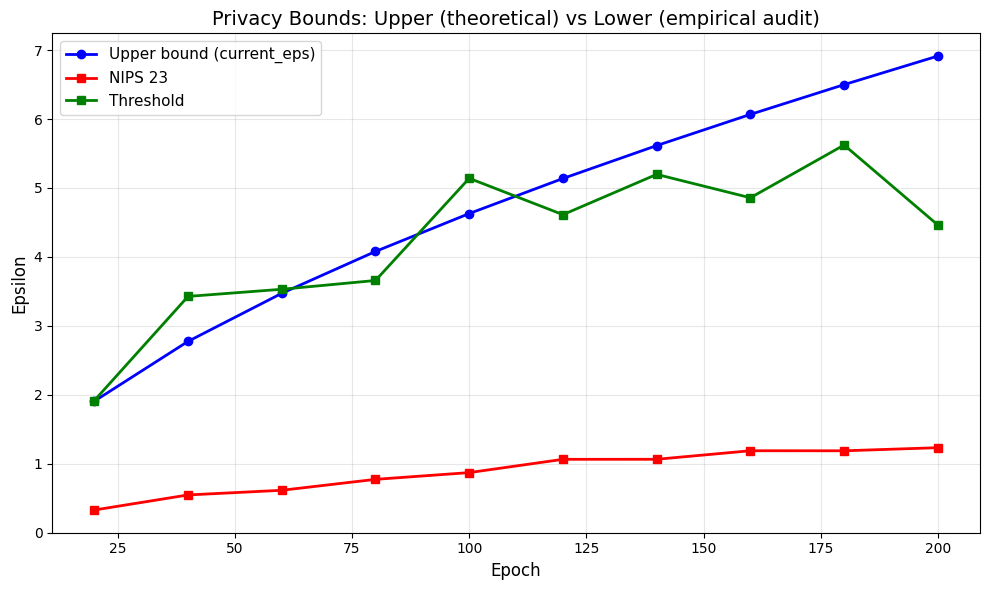

In [ ]:
# Initialize lists to store bounds
epoch_list = []
upper_bounds = []  
default_lower_bounds = []  
threshold_lower_bounds = []  
gaussian_llr_lower_bounds = []
sequence_llr_lower_bounds = []

# Load scores from mislabeled-canaries experiment (in_scores_*.csv, out_scores_*.csv per epoch)
SCORE_EXP_DIR = os.path.join(data_dir, "mislabeled-canaries-90247832174188843591632169492264130834-10000-0.5-cifar10")

for epochs in range(CKPT_INTERVAL, EPOCHS + 1, CKPT_INTERVAL):
    steps = steps_per_epoch * epochs

    privacy_engine.accountant.history.clear()
    privacy_engine.accountant.history.append((NOISE_MULTIPLIER, sample_rate, steps))
    current_eps = privacy_engine.get_epsilon(DELTA)

    in_scores = np.loadtxt(os.path.join(SCORE_EXP_DIR, f"in_scores_{epochs:06d}.csv"))
    out_scores = np.loadtxt(os.path.join(SCORE_EXP_DIR, f"out_scores_{epochs:06d}.csv"))

    auditor = CanaryScoreAuditor(in_scores, out_scores)
    eps_lb_default = auditor.epsilon_one_run(significance=0.05, delta=DELTA)

    auditor = ThresholdAuditor(in_scores, out_scores)
    eps_lb_threshold, _ = auditor.epsilon_one_run(delta=DELTA, smoothing="jeffreys", return_details=True)

    auditor = GaussianLLRAuditor(in_scores, out_scores, steps, sample_rate, MAX_GRAD_NORM, sigma)
    eps_lb_llr, _ = auditor.epsilon_one_run(delta=DELTA, smoothing="jeffreys", return_details=True)

    # Store values
    epoch_list.append(epochs)
    upper_bounds.append(current_eps)
    default_lower_bounds.append(eps_lb_default)
    threshold_lower_bounds.append(eps_lb_threshold)
    gaussian_llr_lower_bounds.append(eps_lb_llr)

    print(f"Epoch {epochs}: Upper bound = {current_eps:.2f}, NIPS 23 = {eps_lb_default:.2f}, Threshold = {eps_lb_threshold:.2f}, Gaussian LLR = {eps_lb_llr:.2f}")

# Plot the bounds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, upper_bounds, marker='o', label='Upper bound (current_eps)', color='blue', linewidth=2)
plt.plot(epoch_list, default_lower_bounds, marker='s', label='NIPS 23', color='red', linewidth=2)
plt.plot(epoch_list, threshold_lower_bounds, marker='s', label='Threshold', color='green', linewidth=2)
# plt.plot(epoch_list, gaussian_llr_lower_bounds, marker='s', label='Gaussian LLR', color='purple', linewidth=2)
# plt.plot(epoch_list, sequence_llr_lower_bounds, marker='s', label='Sequence LLR', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Epsilon', fontsize=12)
plt.title('Privacy Bounds: Upper (theoretical) vs Lower (empirical audit)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
fig_path = os.path.join(fig_dir, 'privacy_bounds_comparison.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {fig_path}")

plt.show()

